In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
import os

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read


def run_decay_analysis(system_root: str) -> str:
    """
    Build a Pariser–Parr–Pople (PPP / Ohno-type) electron–electron interaction matrix
    from a molecular geometry, save it, and visualize interaction decay versus distance
    from each reference site on log–log axes.

    Overview
    --------
    1) Reads an input matrix `U_matrix.txt` only to infer `num_sites` (its dimension).
       The PPP matrix *replaces* the input for the subsequent analysis.

    2) Reads an XYZ geometry (`scatt.xyz`), keeps only C and N atoms, and uses their
       Cartesian coordinates (Å) as sites.

    3) Computes pairwise distances:
        r_ij = || R_i - R_j ||.

    4) Constructs the PPP interaction matrix using an Ohno-like interpolation:
        V_ij = U / sqrt( 1 + alpha * r_ij^2 ),     for i != j
        V_ii = U                                  (onsite term)

       where:
        alpha = (U / 14.397)^2   [1/Å^2]
       The constant 14.397 is the Coulomb conversion factor e^2/(4πϵ0) in eV·Å.
       With this choice, for large r:
        V_ij ~ (U / sqrt(alpha)) * 1/r = 14.397 * 1/r   (eV),
       i.e. it asymptotically approaches a bare Coulomb 1/r tail.

    5) Saves the PPP matrix to:
        {system_root}/output/lowdin/U_matrix_PPP_U_2.0.txt

    6) For each reference site i, plots V_ij versus r_ij (j ≠ i) on log–log axes,
       overlays a visual 1/r guide anchored at the nearest neighbor, and optionally
       performs a purely diagnostic power-law fit:
        V(r) ≈ A * r^{-α_fit}
       via linear regression of log(V) vs log(r).

       NOTE: the PPP/Ohno form is not exactly a pure power-law at short distance,
       so α_fit is only a rough diagnostic of the apparent slope over the sampled range.

    Parameters
    ----------
    system_root : str
        Root directory containing:
          - output/lowdin/U_matrix.txt
          - dft/device/scatt.xyz

    Returns
    -------
    str
        Path to the saved PPP matrix text file.

    Raises
    ------
    FileNotFoundError
        If required input files are missing.
    ValueError
        If U_matrix.txt is not square, or if fewer C/N atoms than num_sites are found.

    Notes
    -----
    Units:
      - Coordinates and distances are assumed in Å (ASE XYZ default).
      - Interactions are in eV.
      - alpha is in 1/Å^2.

    The onsite parameter U is currently hard-coded:
        U_onsite = 2.0 eV
    You can switch to the mean diagonal from the input matrix by uncommenting the line
    shown in the code.

    """
    # ---------------------------
    # Load input U to get num_sites
    # ---------------------------
    U_path = f"{system_root}/output/lowdin/U_matrix.txt"
    U_matrix_in = np.loadtxt(U_path)

    if U_matrix_in.ndim != 2 or U_matrix_in.shape[0] != U_matrix_in.shape[1]:
        raise ValueError(f"U must be a square matrix; got shape {U_matrix_in.shape}")

    num_sites = U_matrix_in.shape[0]

    # ---------------------------
    # PPP setup
    # ---------------------------
    # Use ONE U for everything = average onsite from input matrix (optional):
    # U_onsite = float(np.mean(np.diag(U_matrix_in)))  # eV
    U_onsite = 2.0  # eV

    # Ohno/PPP parameter:
    # alpha = (U / 14.397)^2  [1/Å^2]
    alpha_ppp = (U_onsite / 14.397) ** 2

    # ---------------------------
    # Load geometry: keep only C and N atoms
    # ---------------------------
    xyz_path = f"{system_root}/dft/device/scatt.xyz"
    all_atoms = read(xyz_path)

    is_CN_atom = np.isin(all_atoms.get_chemical_symbols(), ["C", "N"])
    molecular_atoms = all_atoms[is_CN_atom]

    if len(molecular_atoms) < num_sites:
        raise ValueError(
            f"Found only {len(molecular_atoms)} C/N atoms, but U is {num_sites}x{num_sites}."
        )

    # Only use the first num_sites atoms if xyz has more
    site_positions = molecular_atoms.get_positions()  # Å

    # ---------------------------
    # Distance matrix r_ij
    # ---------------------------
    displacement_vectors = site_positions[:, None, :] - site_positions[None, :, :]
    distance_matrix = np.linalg.norm(displacement_vectors, axis=-1)  # Å

    # ---------------------------
    # PPP interaction matrix V_ij
    #   V_ij = U / sqrt(1 + alpha r_ij^2)
    #   V_ii = U
    # ---------------------------
    U_ppp = U_onsite / np.sqrt(1.0 + alpha_ppp * distance_matrix**2)
    np.fill_diagonal(U_ppp, U_onsite)

    # Symmetrize (numerical hygiene)
    U_ppp = 0.5 * (U_ppp + U_ppp.T)

    # ---------------------------
    # Save PPP matrix
    # ---------------------------
    out_dir = f"{system_root}/output/lowdin"
    os.makedirs(out_dir, exist_ok=True)

    ppp_path = f"{out_dir}/U_matrix_PPP_U_{U_onsite:.1f}.txt"
    np.savetxt(ppp_path, U_ppp, fmt="%.10f")

    print(f"\nSaved PPP interaction matrix to:\n  {ppp_path}")
    print(f"Onsite U used: {U_onsite:.6f} eV")
    print(f"PPP alpha parameter: {alpha_ppp:.6f} 1/Å^2\n")

    # From here on, use PPP matrix for decay analysis
    U_matrix = U_ppp

    # ---------------------------
    # Visualization + diagnostic fits
    # ---------------------------
    site_colors = plt.cm.tab10(np.linspace(0, 1, num_sites))
    fitted_decay_exponents = np.full(num_sites, np.nan)

    for reference_site in range(num_sites):
        fig, ax = plt.subplots(figsize=(7, 5))

        partner_sites = np.arange(num_sites)
        partner_sites = partner_sites[partner_sites != reference_site]

        distances_from_i = distance_matrix[reference_site, partner_sites]
        interactions_from_i = U_matrix[reference_site, partner_sites]

        sort_order = np.argsort(distances_from_i)
        distances_from_i = distances_from_i[sort_order]
        interactions_from_i = interactions_from_i[sort_order]

        ax.loglog(
            distances_from_i,
            interactions_from_i,
            "o",
            color=site_colors[reference_site],
            label=f"site {reference_site + 1}",
        )

        # 1/r guide anchored at nearest neighbor:
        # U_ref(r) = U(nn) * r_nn / r
        nearest_distance = distances_from_i[0]
        nearest_interaction = interactions_from_i[0]

        reference_r = np.linspace(distances_from_i.min(), distances_from_i.max(), 200)
        reference_U = nearest_interaction * (nearest_distance / reference_r)

        ax.loglog(
            reference_r,
            reference_U,
            "--",
            color=site_colors[reference_site],
            alpha=0.6,
            label=r"$\propto 1/r$",
        )

        # Diagnostic power-law fit:
        # log(U) = log(A) - α log(r)
        r_fit = distances_from_i.copy()
        U_fit = interactions_from_i.copy()

        mask = (r_fit > 0) & (U_fit > 0)
        r_fit = r_fit[mask]
        U_fit = U_fit[mask]

        if len(r_fit) >= 2:
            x = np.log(r_fit)
            y = np.log(U_fit)
            m, b = np.polyfit(x, y, 1)

            alpha_fit = -m
            A_fit = np.exp(b)
            fitted_decay_exponents[reference_site] = alpha_fit

            rline_fit = np.linspace(r_fit.min(), r_fit.max(), 200)
            Uline_fit = A_fit * rline_fit ** (-alpha_fit)

            ax.loglog(
                rline_fit,
                Uline_fit,
                "-",
                color=site_colors[reference_site],
                alpha=0.8,
                label=rf"fit: $\alpha={alpha_fit:.2f}$",
            )

        ax.set_xlabel(r"$r_{ij}$ (Å)")
        ax.set_ylabel(r"$V_{ij}$ (eV)")
        ax.grid(True, which="both", ls=":")
        ax.legend(fontsize=9)

        plt.tight_layout()
        plt.show()

    # ---------------------------
    # Asymptotic sanity check: r * V should approach ~14.397 eV·Å
    # ---------------------------
    # Get the index of the maximum distance cleanly:
    i_max, j_max = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    print(
        "Asymptotic check (r_max * V(r_max)):",
        distance_matrix[i_max, j_max] * U_ppp[i_max, j_max],
        "eV·Å",
    )

    print("Fitted decay exponents alpha (diagnostic only):")
    for i, a in enumerate(fitted_decay_exponents, start=1):
        print(f"  site {i}: alpha = {a:.3f}" if np.isfinite(a) else f"  site {i}: alpha = n/a")

    return ppp_path



Saved PPP interaction matrix to:
  ../pentadienyl/output/lowdin/U_matrix_PPP_U_2.0.txt
Onsite U used (mean diagonal): 2.000000 eV
PPP alpha parameter: 0.019298 1/Å^2



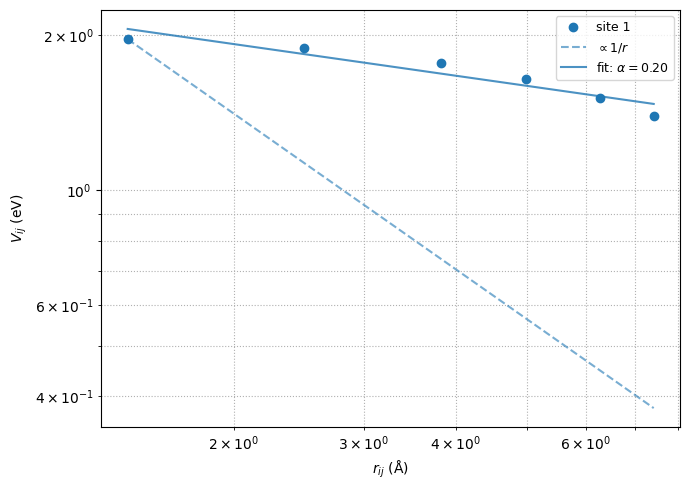

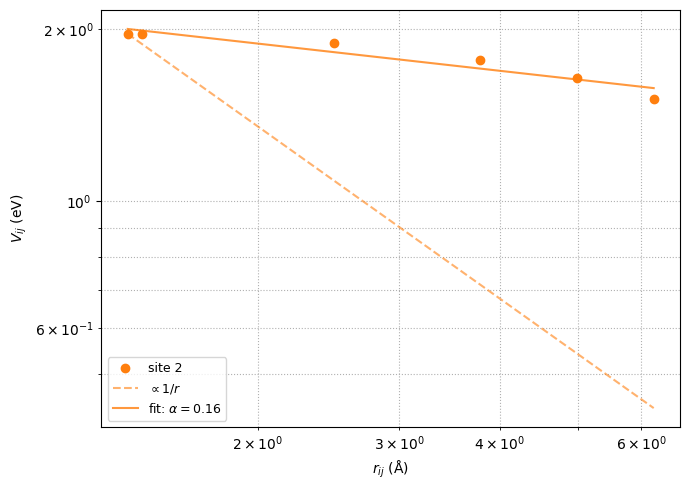

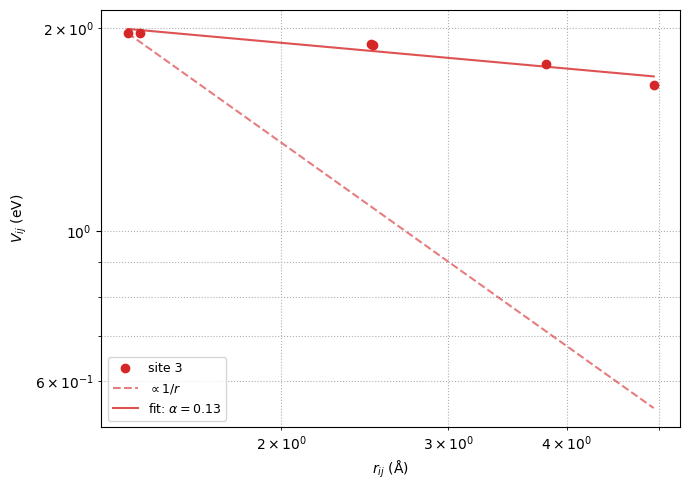

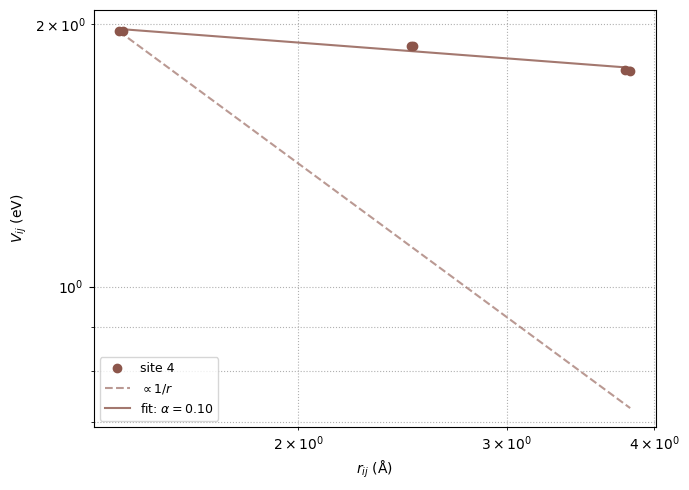

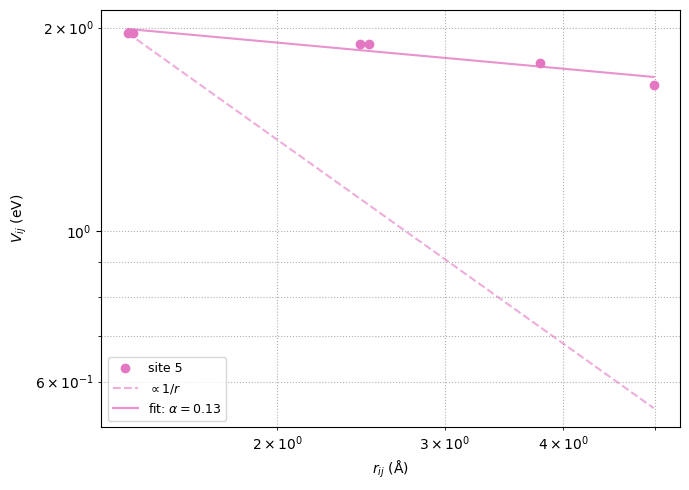

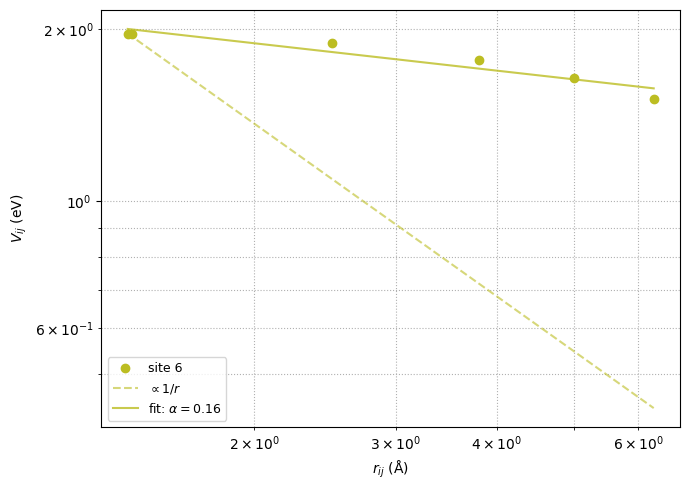

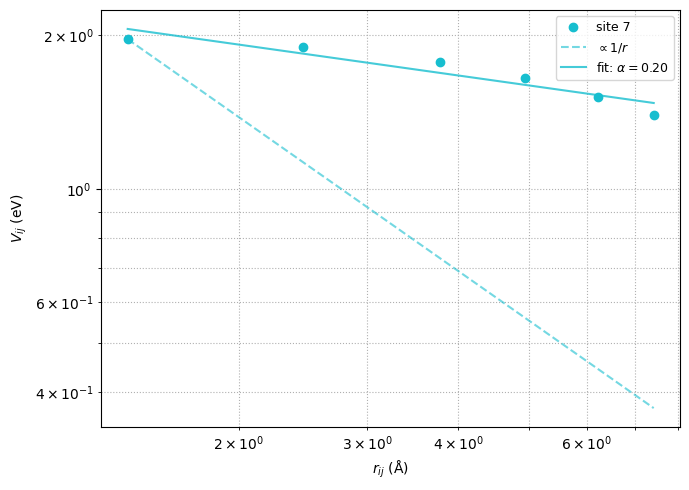

Asymptotic check (r * V at largest distance): 10.332733178890436
Fitted decay exponents alpha (diagnostic only):
  site 1: alpha = 0.203
  site 2: alpha = 0.158
  site 3: alpha = 0.127
  site 4: alpha = 0.103
  site 5: alpha = 0.128
  site 6: alpha = 0.159
  site 7: alpha = 0.201


In [3]:
run_decay_analysis("../pentadienyl")


Saved PPP interaction matrix to:
  ../AuBDA13CH2/output/lowdin/U_matrix_PPP_U_2.0.txt
Onsite U used (mean diagonal): 2.000000 eV
PPP alpha parameter: 0.019298 1/Å^2



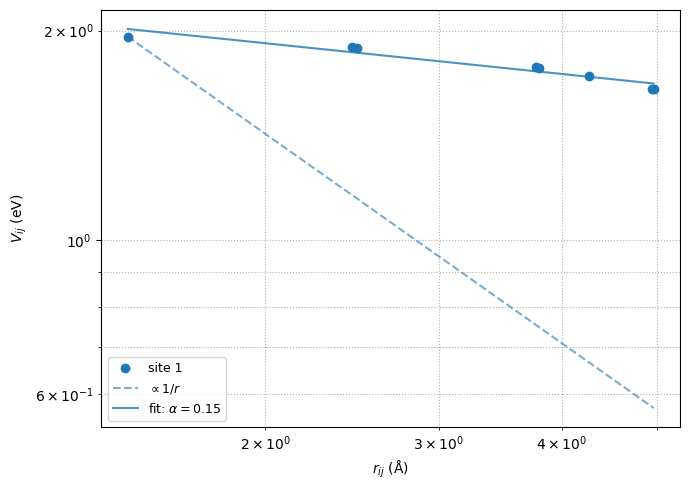

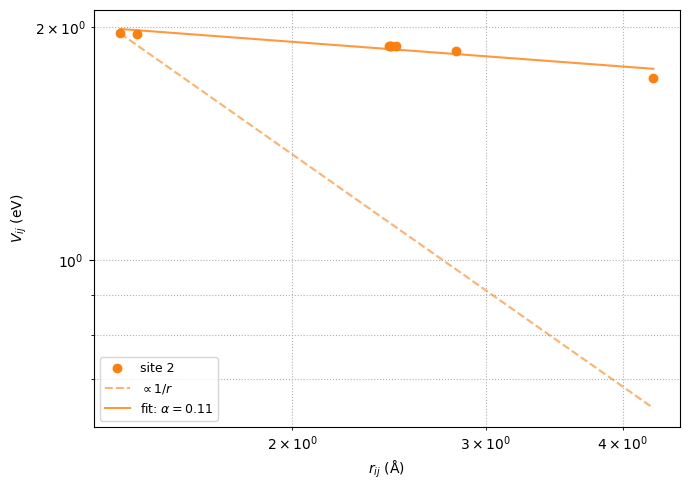

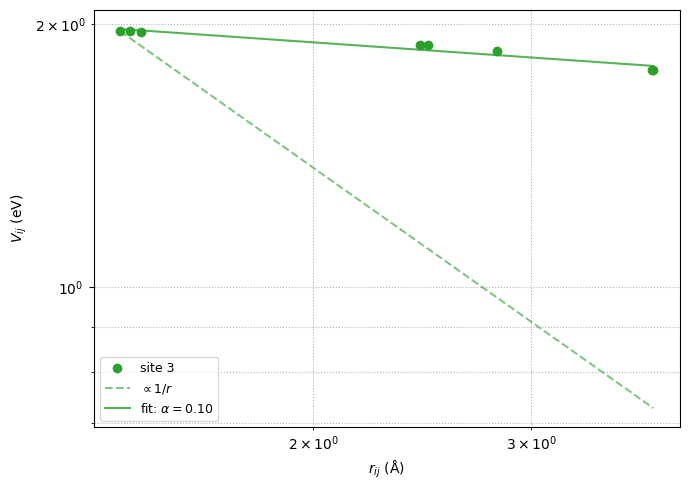

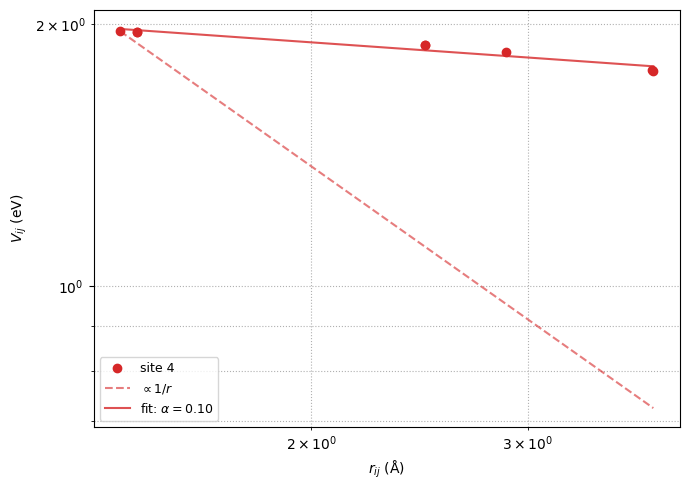

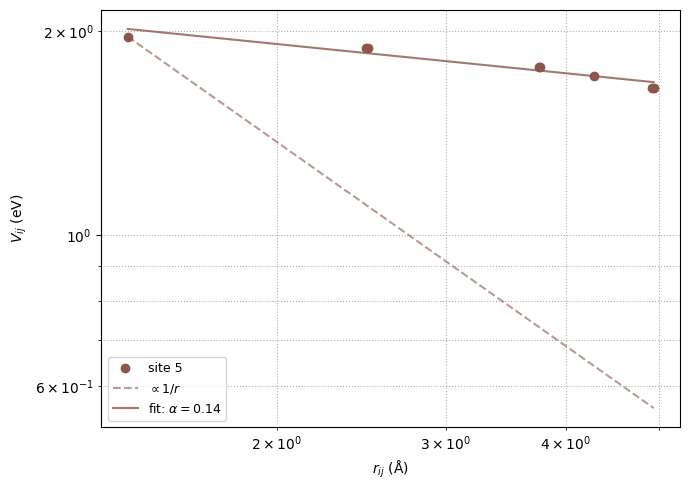

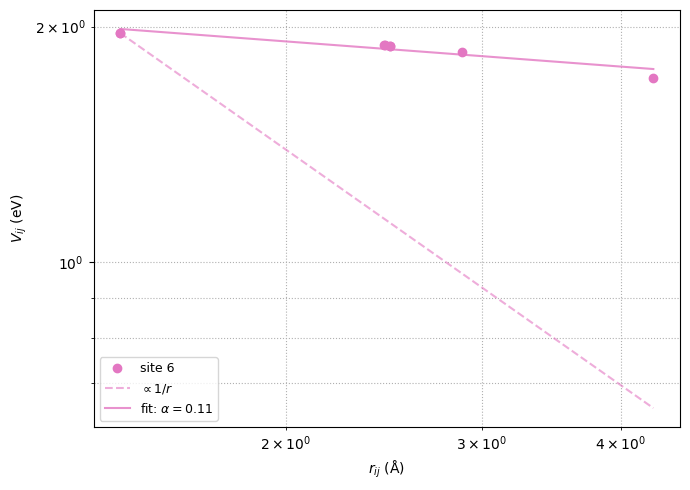

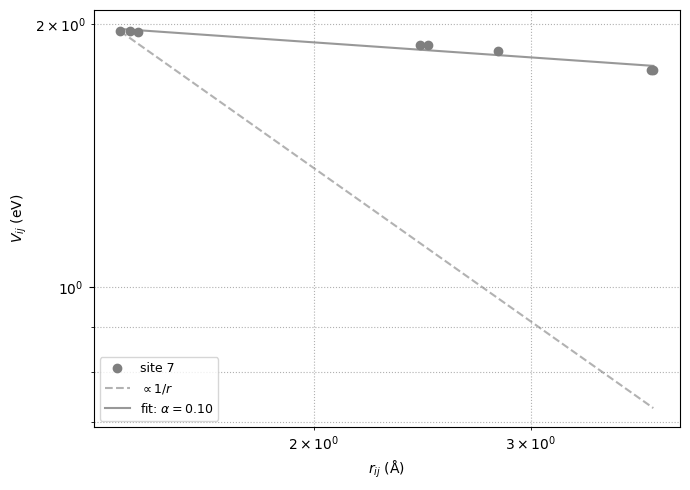

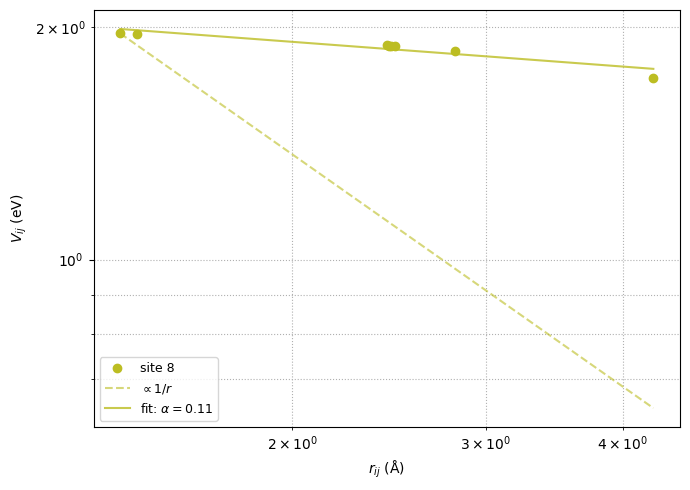

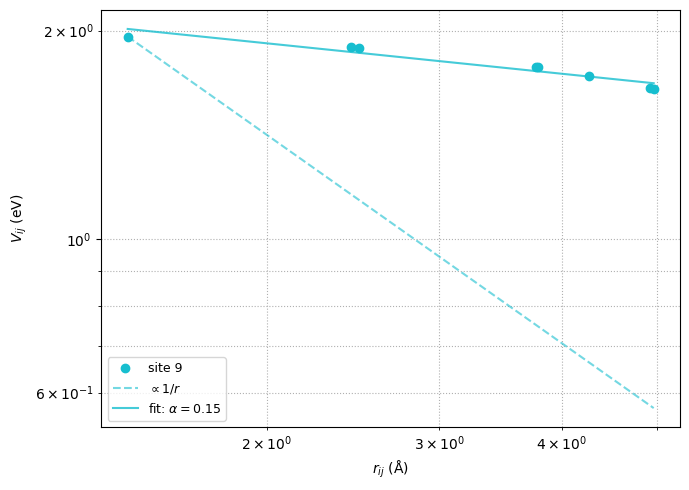

Asymptotic check (r * V at largest distance): 8.171043087992567
Fitted decay exponents alpha (diagnostic only):
  site 1: alpha = 0.147
  site 2: alpha = 0.106
  site 3: alpha = 0.098
  site 4: alpha = 0.099
  site 5: alpha = 0.143
  site 6: alpha = 0.107
  site 7: alpha = 0.098
  site 8: alpha = 0.106
  site 9: alpha = 0.146


In [4]:
run_decay_analysis("../AuBDA13CH2")